# Milestone 02
# Kent Go

In this project, we will use SECOM production dataset and create classification models to determine if we can predict defective products during the manufacturing process by using previously collected data. Some of the classification techniques that we will use include:
    - Decision Tree
    - Ensemble Model (Random Forest & Gradient Boost)
    - Support Vector Matrix
    
After creating the models, we will measure their performance and compare them.

In [1]:
!pip install scikit-plot;

In [2]:
#import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplot
from IPython.display import Image
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, Lasso
from sklearn.svm import SVC

from sklearn.metrics import mutual_info_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module

In [3]:
#define show_tree function

graphviz_path = '/Users/kentg/Anaconda3/envs/uwdatasci420/Library/bin/graphviz'

def show_tree(out_name, model, feature_names):
    dotfile = open(out_name + ".dot", 'w')
    tree.export_graphviz(model, out_file = dotfile, filled = True, rounded = True, feature_names = feature_names)
    dotfile.close()

    os.environ["PATH"] += os.pathsep + graphviz_path
    os.system('dot -Tpng {}.dot -o {}.png'.format(out_name, out_name))

    return(Image(filename = out_name + '.png', width = 500, height = 500))

In [4]:
#define score_plot function

def score_plot(y_test, y_pred, y_predproba):
    
    #calculate accuracy, precision, recall & auc scores

    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred))
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('tn, fp, fn, tp: ', tn, fp, fn, tp, '\n')

    acc_score = accuracy_score(y_test, y_pred)
    print('Accuracy Score: ', acc_score.round(2), '\n')

    prec_score = precision_score(y_test, y_pred, pos_label=1)
    print('Precision Score: ', prec_score.round(2), '\n')

    rec_score = recall_score(y_test, y_pred, pos_label=1)
    print('Recall Score: ', rec_score.round(2), '\n')

    f1 = f1_score(y_test, y_pred) 
    print('F1 Score: ', f1.round(2), '\n')
    
    class_report = classification_report(y_test, y_pred)
    print('Classification Report: \n', class_report,'\n')

    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    rocauc_score = roc_auc_score(y_test, y_predproba[:,1])
    print('ROC AUC Score:', rocauc_score.round(2))

    skplot.metrics.plot_roc_curve(y_test, y_predproba)
    plt.show()

## 0. Prepare & Visually Explore Data

In [5]:
#read & merge data

url1 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'

url2 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'


fnames = ['feature' + str(x) for x in range(1, 591)]
df1 = pd.read_csv(url1, sep=' ', header=None, names=fnames, na_values=np.NaN) 

df2 = pd.read_csv(url2, sep=' ', names=['result','date'], parse_dates=['date'], na_values=np.NaN)

df = pd.concat([df1, df2], axis=1)

print('Dataset shape:', df.shape, '\n')

df.head()

Dataset shape: (1567, 592) 



,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,result,date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 15:22:00


In [6]:
#remove features that are missing more than 50% of their values

missing = pd.DataFrame(df.isnull().sum()/len(df) > 0.5).rename(columns={0: '50%+'})
df2 = df.loc[:, ~missing['50%+']]


#remove non-predictive date feature
df2 = df2.drop('date', axis=1)

print('Shape of Dataset after Removing Features with 50% missing values: ', df2.shape)


#replace remaining missing values with the median value of the feature

df2.replace(np.NaN, df2[df2.columns].median(), inplace=True)

df2.head()

Shape of Dataset after Removing Features with 50% missing values:  (1567, 563)


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,result
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.0205,0.0148,0.0046,71.9005,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


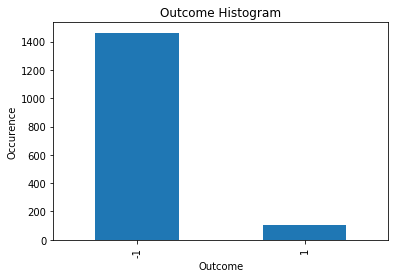

Outcomes: 
 -1    1463
 1     104
Name: result, dtype: int64


In [7]:
#plot histogram of the outcome

df2['result'].value_counts().plot(kind='bar')
plt.title('Outcome Histogram')
plt.xlabel('Outcome')
plt.ylabel('Occurence')
plt.show()

print('Outcomes: \n', df2['result'].value_counts())

After performing EDA and analyzing the distribution, we notice that there are quite a few features that contain the same value in every row. Since these features are non-predictive, we will remove these features to further simplify our dataset. We will also perform SMOTE to handle class imbalance.

In [8]:
#remove features that contain the same value in all rows

cols_to_drop = []

for col in df2.drop('result', axis=1):
    if df2[col].nunique() == 1:
        cols_to_drop.append(col)

print('No. of features that have the same value in all rows: ', len(cols_to_drop), '\n')

df3 = df2.drop(cols_to_drop, axis=1)

print('Shape of Cleaned Dataset: ', df3.shape)

df3.head()

No. of features that have the same value in all rows:  116 

Shape of Cleaned Dataset:  (1567, 447)


,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,result
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.0205,0.0148,0.0046,71.9005,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


## 1. Split Dataset & Handle Class Imbalance

We will split our clean dataset into training and testing sets to be used to build our models.

From the EDA plot, we notice that there's a significant class imbalance: 1463 for Outome = -1 and 104 for Outcome = 1. We need to handle this class imbalance to improve our future score metrics. We will achieve this by applying the SMOTE technique on the dataset.

In [9]:
#split dataset into training & testing sets

X = df3.drop('result', axis=1)
y = df3['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

X_train.shape

(1253, 446)

In [10]:
#standardize features

for col in X_train.columns:
    X_train[col] = StandardScaler().fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = StandardScaler().fit_transform(X_test[col].values.reshape(-1, 1))


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [11]:
#apply smote to training data set to handle class imbalace

sm = SMOTE(random_state=1)

X_res, y_res = sm.fit_sample(X_train, y_train)

X_res = pd.DataFrame(X_res, columns=X.columns)

print('Resampled Training set shape:', X_res.shape)

X_res.head()

Resampled Training set shape: (2338, 446)


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature577,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,-0.958467,0.927414,-0.213151,2.120612,-0.039812,-2.270712,0.145401,-0.562090,0.600873,0.765370,...,4.793848,6.258281,-0.699336,0.051676,-0.089226,0.051674,2.667295,0.128099,-0.080561,-0.716163
1,-1.059013,0.038153,-2.912901,0.331932,-0.056596,-0.367730,0.535309,-0.241626,-0.670973,0.611086,...,-0.226081,0.318446,0.399215,-0.384650,-0.355707,-0.371155,0.025799,-0.256366,-0.283392,-0.372561
2,-1.433269,0.753985,0.100685,2.789345,-0.053158,-2.382131,0.183134,-0.251012,-0.573139,-0.479924,...,-0.254379,0.291199,-0.439153,-0.006151,0.056127,-0.005704,-0.897133,0.204992,0.257492,0.801705
3,0.462867,-0.762006,0.419008,-0.652213,-0.066446,0.487630,-0.106152,1.316443,0.013867,-0.590127,...,-0.233396,-0.689358,-1.046247,-0.247970,-0.186128,-0.233297,-0.411798,1.665959,1.643509,0.956500
4,-0.299609,1.183284,0.760117,0.774160,-0.046100,-0.689973,0.271178,1.197107,-1.740629,0.677208,...,-0.211346,-0.467898,1.121947,-0.016664,-0.040775,-0.021618,-0.395885,-0.377197,-0.486224,-0.227992


In [12]:
#feature selection using lasso technique

lasso = Lasso(alpha=0.05, random_state=1)
lasso.fit(X_res, y_res)


#features chosen

ll = pd.DataFrame({'col': X_res.columns, 'coef': lasso.coef_})

a = 1
lasso_features = []

for i in ll[ll['coef']!=0]['col']:
    ##print(a, '-', i)
    lasso_features.append(i)
    a += 1
    
print('No. of Features Chosen: ', a-1)

No. of Features Chosen:  61


In [13]:
#subset x to only include selected features

X_res2 = X_res[lasso_features]

X_test2 = X_test[lasso_features]

X_res2.head()

,feature10,feature15,feature19,feature22,feature25,feature29,feature32,feature58,feature60,feature63,...,feature542,feature547,feature549,feature562,feature563,feature564,feature570,feature576,feature578,feature583
0,0.600873,-0.079457,-0.465697,0.656700,-0.078612,0.682078,-0.489491,-0.286825,-0.559814,0.555290,...,0.014115,-0.773101,-0.698781,-0.027531,0.638127,0.742904,-0.269688,6.464030,6.258281,-0.699336
1,-0.670973,-1.514262,0.098804,0.631772,-0.661155,1.305874,-0.800096,0.570002,0.268874,-0.202483,...,0.377473,-0.315819,-0.429176,0.544045,0.304862,0.190299,0.303796,0.379354,0.318446,0.399215
2,-0.573139,2.272645,-1.182211,1.218520,-2.026899,1.169016,-0.326172,-1.048449,-0.625276,1.401222,...,-1.164400,-0.759114,0.213583,-0.408390,0.370760,0.261689,1.650594,0.398259,0.291199,-0.439153
3,0.013867,-0.338120,-0.580005,0.226801,0.116371,-0.552769,-0.549151,-0.548633,0.036831,-0.660521,...,0.709838,-0.315819,-0.429176,1.158870,-2.090119,2.189196,-0.274561,-0.960031,-0.689358,-1.046247
4,-1.740629,-0.547063,-0.319421,0.432738,-0.606649,-0.896491,-0.401865,0.546202,-0.086049,-0.602636,...,-1.254044,-0.986613,-0.278273,0.434010,-1.814333,0.719108,2.312571,-0.641545,-0.467898,1.121947


In [14]:
#logistic regression with lasso regularization

logreg = LogisticRegression(random_state=1, penalty='l1', solver='liblinear')

logreg.fit(X_res2, y_res)

y_pred_logreg = logreg.predict(X_test2)
y_predproba_logreg = logreg.predict_proba(X_test2)

acc_logreg = accuracy_score(y_test, y_pred_logreg)

print('Logistic Regression Accuracy Score: ', acc_logreg.round(3), '\n')

Logistic Regression Accuracy Score:  0.809 



## 2. Decision Tree Model

The first model that we're going to apply is the tree-based Decision Tree model. We will use GridSearchCV to tune the hyperparameters and find the ones that will give us a high performing tree model. We will also build and visualize the resulting tree model and top 15 most important features.

In [15]:
#use grid seach cv to find best hyperparameters

param_grid_tree = {'criterion': ['gini', 'entropy'],
                  'max_depth': np.arange(5,10),
                  'min_samples_leaf': np.arange(20,30)}

tree_cv = GridSearchCV(DecisionTreeClassifier(random_state=1), 
                       param_grid_tree, refit = True,
                       n_jobs=-1)

tree_cv.fit(X_res2, y_res)

tree_cv.best_params_

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 28}

Decision Tree Accuracy Score:  0.761 



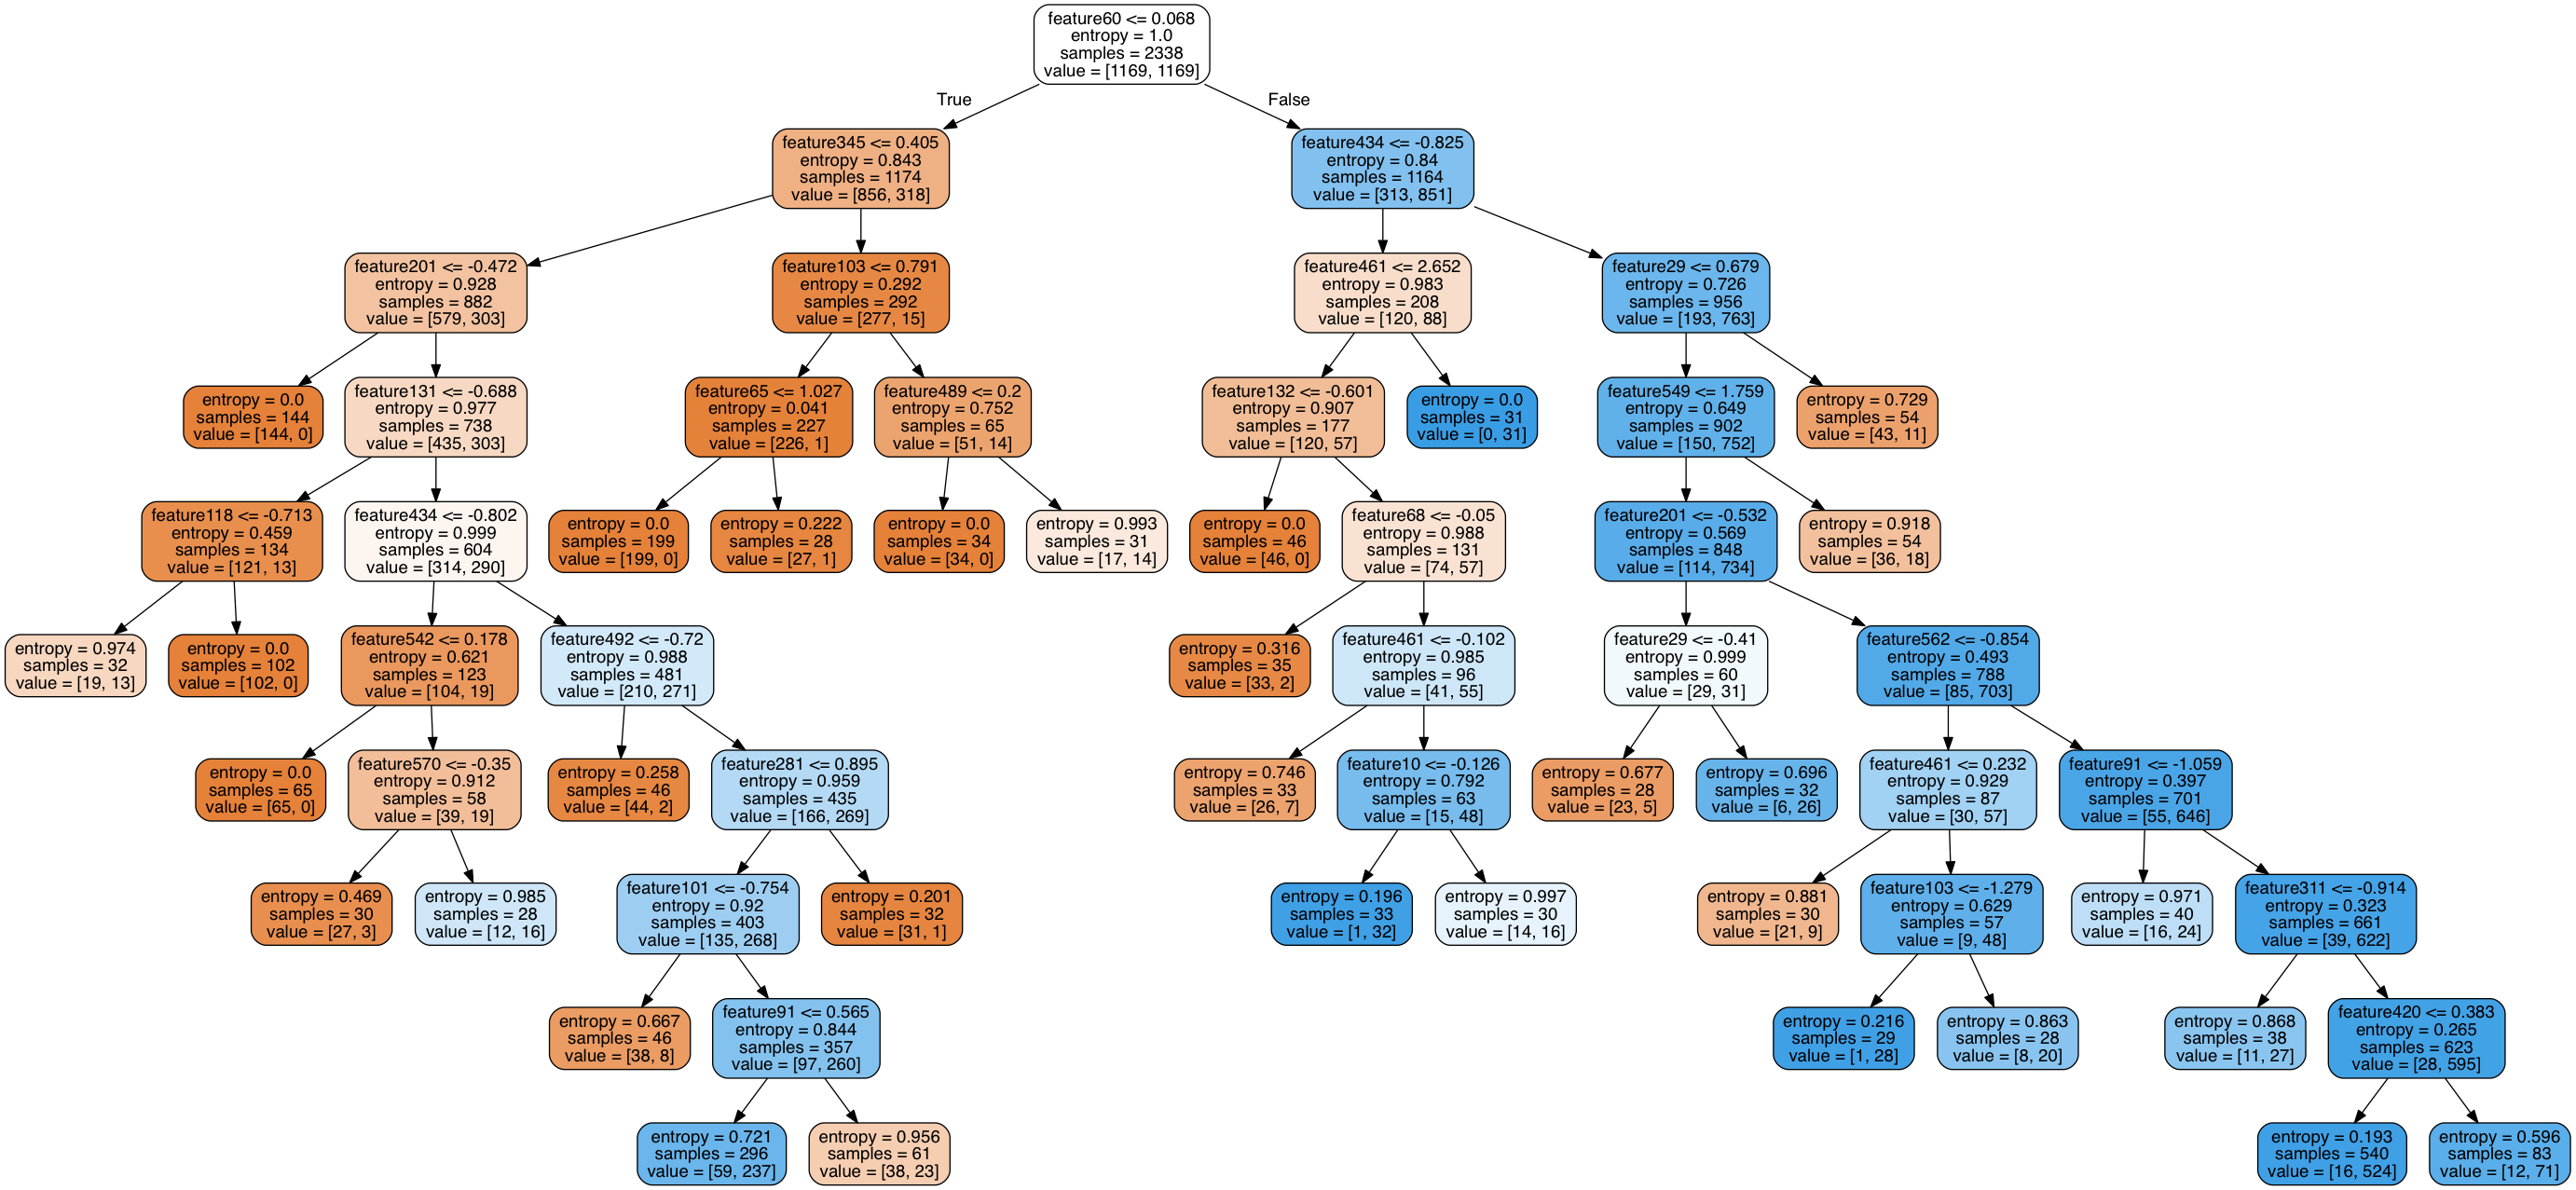

In [16]:
#tree model predictions

y_pred_tree = tree_cv.predict(X_test2)
y_predproba_tree = tree_cv.predict_proba(X_test2)

acc_tree = accuracy_score(y_test, y_pred_tree)

print('Decision Tree Accuracy Score: ', acc_tree.round(3), '\n')

show_tree('decision_tree', tree_cv.best_estimator_, X_res2.columns)

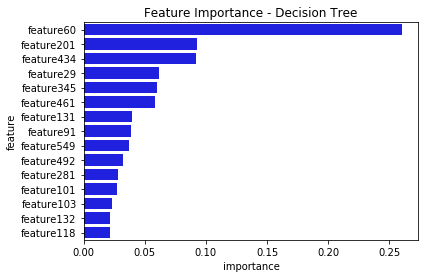

In [17]:
#feature importance

df_var_imp1 = pd.DataFrame({"feature": X_res2.columns, 
                           "importance": tree_cv.best_estimator_.feature_importances_})
df_var_imp1.sort_values(by = "importance", ascending = False, inplace = True)

ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp1.head(15), color = "blue")
ax.set_title('Feature Importance - Decision Tree');

## 3. Ensemble Model

We will use Random Forest and Gradient Boost methods to create models for our classification project. We will also perform hyperparameter tuning using GridSearchCV for each model.

### 3.1 Random Forest

The first ensemble model that we're going to apply is the Random Forest model. We will use GridSearchCV to tune the hyperparameters and find the ones that will give us a high performing model.

Running GridSearchCV is a fairly time consuming process. We run the GridSearchCV once and determine that the best hyperparameters are: {'max_depth': 18, 'min_samples_leaf': 10, 'n_estimators': 300}

#use grid seach cv to find best hyperparameters

param_grid_forest = {'n_estimators': np.arange(100,500,100),
                  'max_depth': np.arange(10,20),
                  'min_samples_leaf': np.arange(10,20)}

forest_cv = GridSearchCV(RandomForestClassifier(random_state=1), 
                         param_grid_forest, 
                         refit = True,
                         n_jobs = -1,
                         verbose = 10)

forest_cv.fit(X_res2, y_res)

forest_cv.best_params_

In [18]:
#random forest

hypers = {'n_estimators': 300,
          'max_depth': 18, 
          'min_samples_leaf': 10}

rforest = RandomForestClassifier(random_state = 1, verbose = True, **hypers)

rforest.fit(X_res2, y_res)

y_pred_forest = rforest.predict(X_test2)
y_predproba_forest = rforest.predict_proba(X_test2)

acc_forest = accuracy_score(y_test, y_pred_forest)

print('Random Forest Accuracy Score: ', acc_forest.round(3), '\n')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Random Forest Accuracy Score:  0.908 



[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


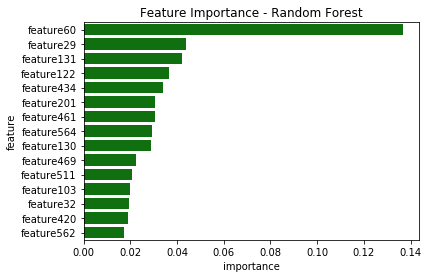

In [19]:
#feature importance

df_var_imp2 = pd.DataFrame({"feature": X_res2.columns, 
                           "importance": rforest.feature_importances_})
df_var_imp2.sort_values(by = "importance", ascending = False, inplace = True)

ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp2.head(15), color = "green")
ax.set_title('Feature Importance - Random Forest');

### 3.2 Gradient Boost

The second ensemble model that we're going to apply is the Gradient Boost model. We will use GridSearchCV to tune the hyperparameters and find the ones that will give us a high performing model.

Running GridSearchCV is a fairly time consuming process. We run the GridSearchCV once and determine that the best hyperparameters are: 
{'learning_rate': 0.25,
 'loss': 'exponential',
 'max_depth': 19,
 'min_samples_leaf': 19,
 'n_estimators': 100}

#use grid seach cv to find best hyperparameters

param_grid_boost = {'loss': ['deviance', 'exponential'],
                  'n_estimators': np.arange(100,500,100),
                  'max_depth': np.arange(10,20),
                  'min_samples_leaf': np.arange(10,20),
                  'learning_rate': np.arange(0.25,1,0.25)}

boost_cv = GridSearchCV(GradientBoostingClassifier(random_state=1), 
                        param_grid_boost, refit = True, 
                        n_jobs=-1, verbose=10)

boost_cv.fit(X_res2, y_res)

boost_cv.best_params_

In [20]:
#gradient boost

hypers2 = {'learning_rate': 0.25,
             'loss': 'exponential',
             'max_depth': 19,
             'min_samples_leaf': 19,
             'n_estimators': 100}

gboost = GradientBoostingClassifier(**hypers2, random_state=1);

gboost.fit(X_res2, y_res);

y_pred_boost = gboost.predict(X_test2)
y_predproba_boost = gboost.predict_proba(X_test2)

acc_boost = accuracy_score(y_test, y_pred_boost)

print('Gradient boost Accuracy Score: ', acc_boost.round(3), '\n')

Gradient boost Accuracy Score:  0.917 



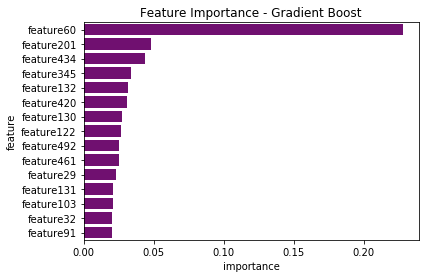

In [21]:
#feature importance

df_var_imp3 = pd.DataFrame({"feature": X_res2.columns, 
                           "importance": gboost.feature_importances_})
df_var_imp3.sort_values(by = "importance", ascending = False, inplace = True)

ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp3.head(15), color = "purple")
ax.set_title('Feature Importance - Gradient Boost');

## 4. SVM Classification Model

The next classification technique that we will use is the Support Vector Matrix Classification technique. We will use GridSearchCV to tune the hyperparameters and find the ones that will give us a high performing tree model.

In [22]:
#use gridsearchcv to get best params

hyper_parameter_space = {'kernel': ['poly', 'rbf'], 
                         'degree': [1, 10],
                         'C': [1, 10],
                         'gamma': ['scale', 'auto']} 


svc_cv = GridSearchCV(SVC(probability = True, cache_size = 1024, random_state=1), 
                      hyper_parameter_space, 
                      cv = 5, refit = True, 
                      return_train_score = True,
                      n_jobs=-1, 
                      verbose=10)

svc_cv.fit(X_res2, y_res)

svc_cv.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   15.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.0s finished


{'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [23]:
y_pred_svc = svc_cv.predict(X_test2)
y_predproba_svc = svc_cv.predict_proba(X_test2)

acc_svc = accuracy_score(y_test, y_pred_svc)

print('SVC Accuracy Score: ', acc_svc.round(3), '\n')

SVC Accuracy Score:  0.946 



## 5. Evalute Models

The next step is to evaluate each model's performance and scores. We will also plot the confusion matrix as well as the ROC-AUC plot.

### 5.1 Decision Tree Performance & Scores

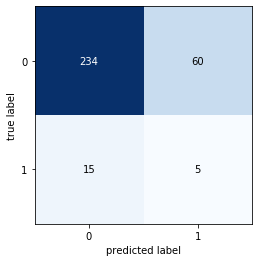

tn, fp, fn, tp:  234 60 15 5 

Accuracy Score:  0.76 

Precision Score:  0.08 

Recall Score:  0.25 

F1 Score:  0.12 

Classification Report: 
               precision    recall  f1-score   support

          -1       0.94      0.80      0.86       294
           1       0.08      0.25      0.12        20

    accuracy                           0.76       314
   macro avg       0.51      0.52      0.49       314
weighted avg       0.88      0.76      0.81       314
 

ROC AUC Score: 0.58


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


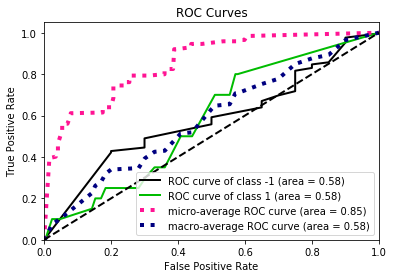

In [24]:
#calculate accuracy, precision, recall & auc scores

score_plot(y_test, y_pred_tree, y_predproba_tree)

### 5.2 Random Forest Performance & Scores

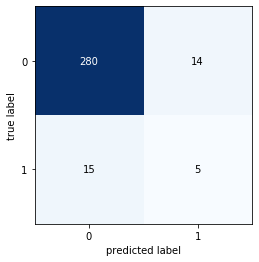

tn, fp, fn, tp:  280 14 15 5 

Accuracy Score:  0.91 

Precision Score:  0.26 

Recall Score:  0.25 

F1 Score:  0.26 

Classification Report: 
               precision    recall  f1-score   support

          -1       0.95      0.95      0.95       294
           1       0.26      0.25      0.26        20

    accuracy                           0.91       314
   macro avg       0.61      0.60      0.60       314
weighted avg       0.91      0.91      0.91       314
 

ROC AUC Score: 0.76


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


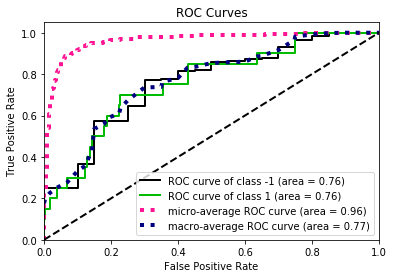

In [25]:
#calculate accuracy, precision, recall & auc scores

score_plot(y_test, y_pred_forest, y_predproba_forest)

### 5.3 Gradient Boost Performance & Scores

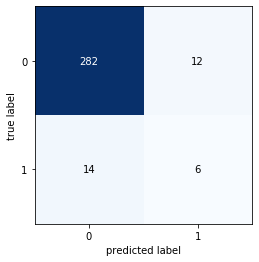

tn, fp, fn, tp:  282 12 14 6 

Accuracy Score:  0.92 

Precision Score:  0.33 

Recall Score:  0.3 

F1 Score:  0.32 

Classification Report: 
               precision    recall  f1-score   support

          -1       0.95      0.96      0.96       294
           1       0.33      0.30      0.32        20

    accuracy                           0.92       314
   macro avg       0.64      0.63      0.64       314
weighted avg       0.91      0.92      0.92       314
 

ROC AUC Score: 0.72


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


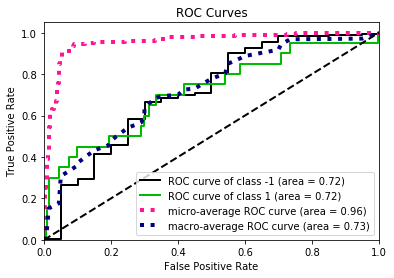

In [26]:
#calculate accuracy, precision, recall & auc scores

score_plot(y_test, y_pred_boost, y_predproba_boost)

### 5.4 SVC Performance & Scores

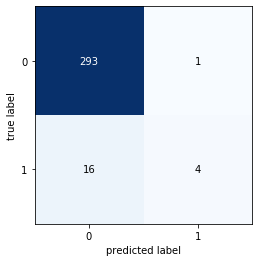

tn, fp, fn, tp:  293 1 16 4 

Accuracy Score:  0.95 

Precision Score:  0.8 

Recall Score:  0.2 

F1 Score:  0.32 

Classification Report: 
               precision    recall  f1-score   support

          -1       0.95      1.00      0.97       294
           1       0.80      0.20      0.32        20

    accuracy                           0.95       314
   macro avg       0.87      0.60      0.65       314
weighted avg       0.94      0.95      0.93       314
 

ROC AUC Score: 0.6


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


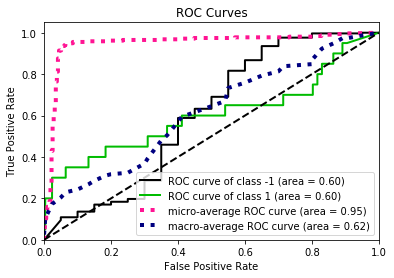

In [27]:
#calculate accuracy, precision, recall & auc scores

score_plot(y_test, y_pred_svc, y_predproba_svc)

### 5.5 Logistic Regression Performance & Scores

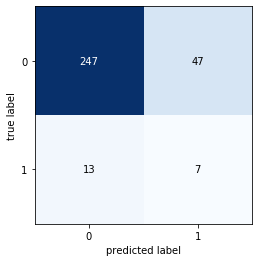

tn, fp, fn, tp:  247 47 13 7 

Accuracy Score:  0.81 

Precision Score:  0.13 

Recall Score:  0.35 

F1 Score:  0.19 

Classification Report: 
               precision    recall  f1-score   support

          -1       0.95      0.84      0.89       294
           1       0.13      0.35      0.19        20

    accuracy                           0.81       314
   macro avg       0.54      0.60      0.54       314
weighted avg       0.90      0.81      0.85       314
 

ROC AUC Score: 0.64


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


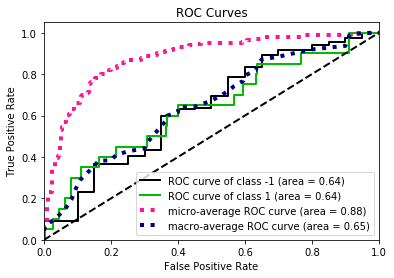

In [28]:
#calculate accuracy, precision, recall & auc scores

score_plot(y_test, y_pred_logreg, y_predproba_logreg)

### 5.6 Performance Comparison

We use the rebalanced, scaled and feature selected dataset to create the models. The performance summary can be found below.

| Technique | Accuracy | Precision | Recall | AUC |
| --- | --- | --- | --- | --- |
| Decision Tree | 0.76 | 0.08 | 0.25 | 0.58 |
| Random Forest | 0.91 | 0.26 | 0.25 | 0.76 |
| Gradient Boost | 0.92 | 0.33 | 0.30 | 0.72 |
| SVC | 0.95 | 0.80 | 0.20 | 0.60 |
| Logistic Regression | 0.81 | 0.13 | 0.35 | 0.64 |

We see that SVC has the best Accuracy and Precision scores. The Recall and AUC scores are not as good as the other models. This indicates that the model produces many false negative predictions. However, the much higher Accuracy and Precision scores indicate that SVC is the best model compared the other models.


## 6. Findings & Discussion

Our main goal for this project is to create Tree, Ensemble (random forest and gradient boost) as SVM classification models to predict and identify defective products during the production process. To achieve this, we will use data collected from sensors installed throughout the manufacturing process.

We performed data engineering, dataset split, class balancing and feature selection prior to creating our models to simplify our dataset and prevent overfitting. We then created several different models (Decision Tree, Random Forest, Gradient Boost and SVC) to determine which model gives us the best scores (accuracy, precision, recall & AUC). We also performed hyperparameter tuning (using Grid Search CV) for each model to identify the best hyperparameters to use.

Based on the model performance summary above, the SVC model outperforms the other models due to its high Accuracy and Precision scores. The second best model is Gradient Boost because it has the best Recall score (albeit still fairly poor) compared to the other models.

The model will allow our client to identify defective products during the manufacturing process. However, the poor Recall score (high false negative) indicates that some defective products are not caught and we need to improve our model.